# **GNN_Energy.ipynb: Energy prediction for EIC Det2 KLM**
This notebook walks through the steps of loading data, training and testing a GNN for energy prediction tasks

In [1]:
# import matplotlib.pyplot as plot
import pandas as pd
import os
os.environ["DGLBACKEND"] = "pytorch"
import dgl
import torch
from dgl.data import DGLDataset
import matplotlib.pyplot as plot
import numpy as np
import torch.nn as nn
import torch
import itertools
import dgl.data
import torch.nn.functional as F
from dgl.dataloading import GraphDataLoader
from tqdm import tqdm
import matplotlib.pyplot as plot
from datetime import datetime as datetime
current_date = datetime.now().strftime("%B_%d")
from torch.utils.data.sampler import SubsetRandomSampler
from GNN_util import process_df_vectorized,create_directory,HitDataset,create_fast_edge_lists,visualize_detector_graph,GIN,train_GNN,test_GNN,calculate_bin_rmse

/hpc/group/vossenlab/rck32/ML_venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


## **Load in Data**
The data is stored as pandas dataframes where each row is a hit in the detector

In [2]:
num_dfs = 1000
dfs = []
for i in range(num_dfs):
    try:
        new_df = pd.read_csv(f"/hpc/group/vossenlab/rck32/eic/work_eic/macros/Timing_estimation/data/df/jan_18_50events_{i}.csv")
    except FileNotFoundError as e:
        # Skip files that failed for some reason...
        # I think these files fail due to DCC issues?
        print(f"skipping file #{i}...")
        continue
    new_df["file_idx"] = i
    dfs.append(new_df)
data = pd.concat(dfs)

skipping file #110...
skipping file #128...
skipping file #238...
skipping file #403...
skipping file #469...
skipping file #505...
skipping file #535...
skipping file #561...
skipping file #590...
skipping file #601...
skipping file #648...
skipping file #684...
skipping file #685...
skipping file #748...
skipping file #760...
skipping file #774...
skipping file #776...
skipping file #786...
skipping file #840...
skipping file #872...
skipping file #894...
skipping file #928...
skipping file #929...
skipping file #963...
skipping file #989...


## **Isolate hits in one section of detector**

Because we sometimes get backscattering and other weird detector effects, we want to train the GNN on a cluster of events that are all together, and treat hits that are far away as noise. This implementation allows the user to set how far away the hits can be and still be clustered together

In [3]:
# Plot the data
modified_df = process_df_vectorized(data, cone_angle_deg = 22)

## **Define the dataset class for easy management**

The HitDataset class inherits from the DGLDataset. The required member functions are the init method, process, getitem, and len.

In [4]:
dataset = HitDataset(modified_df,True)
print("done")

done


## **Optionally, we can visualize any of the input graphs below**

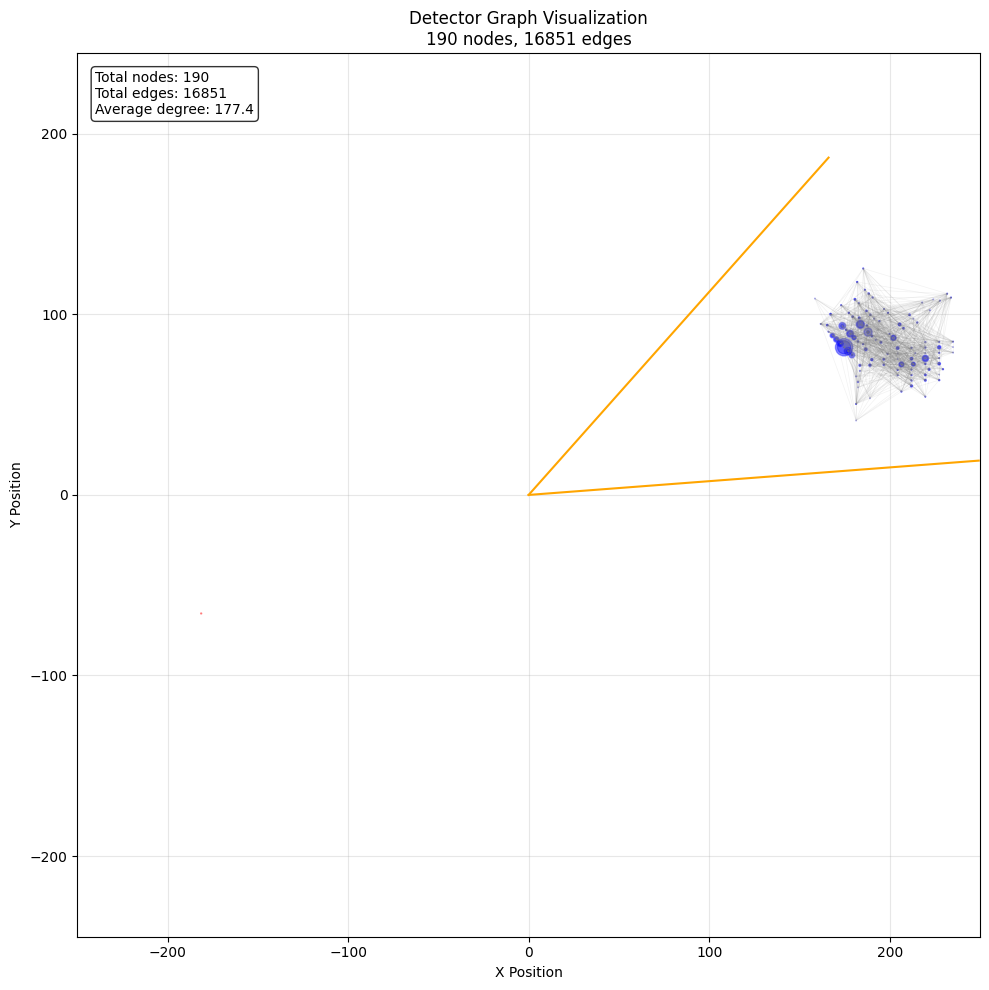

In [5]:
event_groups = modified_df.groupby(["event_idx","file_idx"])
event_1 = event_groups.get_group((8,0))
srcs, dests = create_fast_edge_lists(event_1,200)
visualize_detector_graph(event_1,srcs,dests)

## **Define dataloader**

We use a dataloader to make batching easier, and to randomly split test and train

In [6]:
train_frac = 0.7
val_frac = 0.15
num_train = int(np.floor(len(dataset) * train_frac))
num_val = int(np.floor(len(dataset) * val_frac))
num_examples = len(dataset)

train_sampler = SubsetRandomSampler(torch.arange(num_train))
val_sampler = SubsetRandomSampler(torch.arange(num_train, num_val + num_train))
test_sampler = SubsetRandomSampler(torch.arange(num_val + num_train, num_examples))

train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler, batch_size=20, drop_last=False
)

val_dataloader = GraphDataLoader(
    dataset, sampler=val_sampler, batch_size=20, drop_last=False
)

test_dataloader = GraphDataLoader(
    dataset, sampler=test_sampler, batch_size=20, drop_last=False
)

## **Initialize the model and define the optimizer/criterion**

In [7]:
hidden_dim = 6
model = GIN(dataset.dim_nfeats, hidden_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

*Now we can actually train the model*

In [8]:
def train_GNN(model,optimizer,criterion, train_dataloader, val_dataloader, n_epochs,early_stopping_limit):
    create_directory(f"models/GNN_Energy_prediction/{current_date}/")
    val_mse = []
    val_mse_all = []
    train_losses = []
    train_losses_all = []
    early_stopping_dict = {
            "lowest_loss" : -1,
            "best_model_path" : "",
            "num_upticks" : 0
    }
    # 0: loss; 1: path; 2: # hits

    for epoch in range(n_epochs):
        # Training phase
        model.train()
        num_train_batches = 0
        epoch_train_losses = 0.0

        for batched_graph, labels in train_dataloader:
            pred = model(batched_graph, batched_graph.ndata["feat"].float())

            # Compute loss and update the model
            loss = criterion(pred, labels.unsqueeze(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_losses+=loss.detach()
            train_losses_all.append(loss.detach())
            num_train_batches += 1

        # Average RMSE for the epoch
        this_epoch_loss = epoch_train_losses / num_train_batches
        train_losses.append(this_epoch_loss)
        print(f"Epoch {epoch + 1}/{n_epochs} - Train loss:\t {this_epoch_loss:.4f}")

        # Testing phase
        model.eval()
        epoch_val_mse = 0.0
        num_val_batches = 0

        with torch.no_grad():  # Disable gradients for evaluation
            for batched_graph, labels in val_dataloader:
                pred = model(batched_graph, batched_graph.ndata["feat"].float())
                # Calculate RMSE for this batch
                batch_mse = criterion(pred, labels.unsqueeze(-1))
                epoch_val_mse += batch_mse
                num_val_batches += 1
                val_mse_all.append(batch_mse)

        # Average RMSE for the test set
        epoch_val_mse /= num_val_batches
        val_mse.append(epoch_val_mse)
        print(f"Epoch {epoch + 1}/{n_epochs} - Validation MSE:\t {epoch_val_mse:.4f}\n")
        if(epoch_val_mse.item() < early_stopping_dict["lowest_loss"] or early_stopping_dict["lowest_loss"] == -1):
            early_stopping_dict["lowest_loss"] = epoch_val_mse
            early_stopping_dict["best_model_path"] = f"models/GNN_Energy_prediction/{current_date}/events50k_lr0_001_hiddendim6_epoch{epoch}.pth"
            torch.save(model.state_dict(),early_stopping_dict["best_model_path"])
        elif(epoch_val_mse.item() > early_stopping_dict["lowest_loss"]):
            early_stopping_dict["num_upticks"] += 1
            print("Test loss increased, adding uptick")
        if(early_stopping_dict["num_upticks"] >= early_stopping_limit):
            # Stop training, load best model
            model.load_state_dict(torch.load(early_stopping_dict["best_model_path"]))
            torch.save(model.state_dict(),f"models/GNN_Energy_prediction/{current_date}/events50k_lr0_001_hiddendim6_best.pth")
            print("Stopping early, loading best model...")
            break
    return model, train_losses, val_mse

In [9]:
n_epochs = 30
early_stopping_limit = 5
trained_model, train_losses, val_losses = train_GNN(model,optimizer,criterion, train_dataloader, val_dataloader, n_epochs, early_stopping_limit)

Epoch 1/30 - Train loss:	 361300656128.0000
Epoch 1/30 - Validation MSE:	 13963521024.0000

Epoch 2/30 - Train loss:	 6921256960.0000
Epoch 2/30 - Validation MSE:	 1461747200.0000

Epoch 3/30 - Train loss:	 2714262016.0000
Epoch 3/30 - Validation MSE:	 681897472.0000

Epoch 4/30 - Train loss:	 6042013696.0000
Epoch 4/30 - Validation MSE:	 129207136.0000

Epoch 5/30 - Train loss:	 150757872.0000
Epoch 5/30 - Validation MSE:	 206133616.0000

Test loss increased, adding uptick
Epoch 6/30 - Train loss:	 960296896.0000
Epoch 6/30 - Validation MSE:	 2737032704.0000

Test loss increased, adding uptick
Epoch 7/30 - Train loss:	 415779872.0000
Epoch 7/30 - Validation MSE:	 13827991.0000

Epoch 8/30 - Train loss:	 179093024.0000
Epoch 8/30 - Validation MSE:	 1406388.0000

Epoch 9/30 - Train loss:	 24659952.0000
Epoch 9/30 - Validation MSE:	 407035.3750

Epoch 10/30 - Train loss:	 724817.9375
Epoch 10/30 - Validation MSE:	 311382.9688

Epoch 11/30 - Train loss:	 8783569.0000
Epoch 11/30 - Validat

/tmp/ipykernel_2169234/1862281660.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopping_dict["best_model_path"]))


## **Plot training and val loss on log scale**

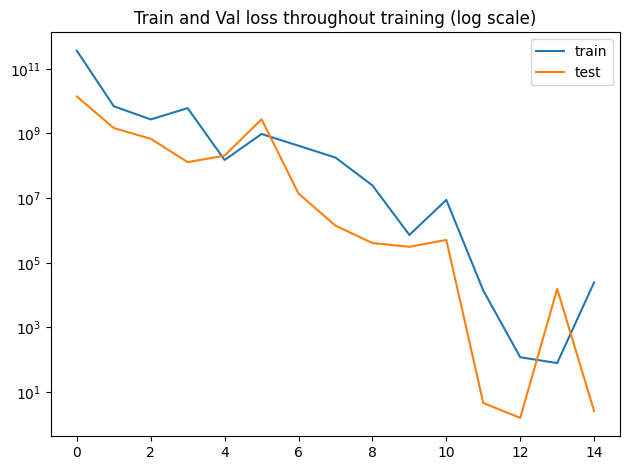

In [10]:
plot.plot(train_losses,label = "train")
plot.title("Train and Val loss throughout training (log scale)")
plot.plot(val_losses, label = "test")
plot.yscale("log")
plot.legend()
plot.tight_layout()

## **Evaluate model on test dataset**

Now we can check the RMSE and across the whole test dataset and visualize the result

MSE: 991.7243041992188


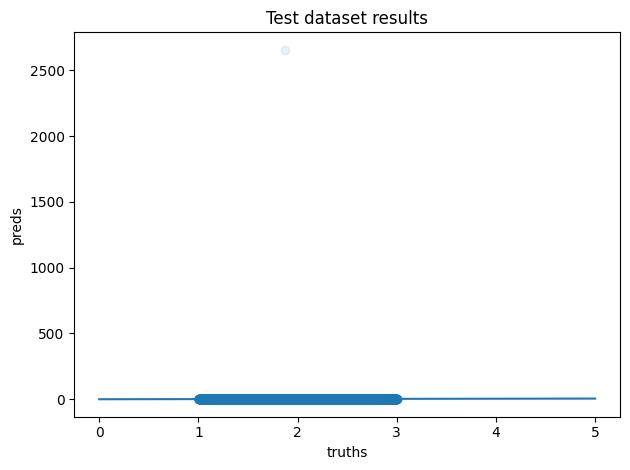

In [11]:
test_truths, test_preds = test_GNN(trained_model, test_dataloader)

plot.plot([0,5],[0,5])
plot.title("Test dataset results")
plot.scatter(test_truths,test_preds,alpha = 0.1)
plot.xlabel("truths")
plot.ylabel("preds")
plot.tight_layout()

# Binned RMSE

In [12]:
rmse_per_bin = calculate_bin_rmse(test_dataloader, model)

In [13]:
bin_centers = np.array(list(rmse_per_bin.keys()))
rmse = np.array(list(rmse_per_bin.values()))
rel_rmse = rmse / bin_centers

In [14]:
def func(x, A):
    return A / np.sqrt(x)
from scipy.optimize import curve_fit

params, cov = curve_fit(func, bin_centers, rel_rmse)
x_fit = np.linspace(1, 3, 100)
y_fit = func(x_fit, params)

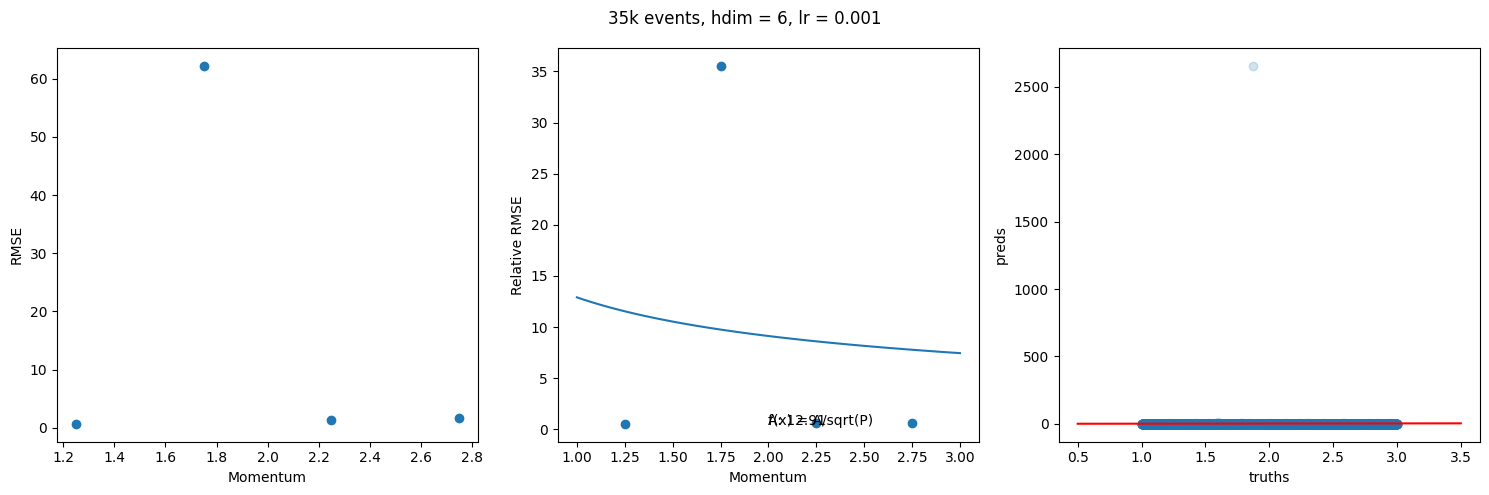

In [15]:
fig,axs = plot.subplots(1,3,figsize = (15,5))
fig.suptitle("35k events, hdim = 6, lr = 0.001")
axs[0].scatter(rmse_per_bin.keys(),rmse_per_bin.values())
axs[0].set(xlabel="Momentum",ylabel = "RMSE")
axs[1].scatter(rmse_per_bin.keys(),np.array(list(rmse_per_bin.values())) / np.array(list(rmse_per_bin.keys())))
axs[1].plot(x_fit,y_fit)
axs[1].set(xlabel="Momentum",ylabel = "Relative RMSE")
axs[1].text(2,0.4,f"A: {params[0]:.2f}")
axs[1].text(2,0.42,f"f(x) = A/sqrt(P)")
axs[2].scatter(test_truths,test_preds,alpha = 0.2)
axs[2].plot([0.5,3.5],[0.5,3.5],color = "red")
axs[2].set(xlabel = "truths",ylabel = "preds")
fig.tight_layout()
plot.savefig("plots/GNN/RMSE_50kevents_hdim6_lr0_001_GIN.pdf")